A brain tumor is a collection, or mass, of abnormal cells in the brain. It can be cancerous (malignant) or noncancerous (benign), both potentially life-threatening.
<br>
These tumors come in a wide variety of sizes, textures, and locations. When trying to locate them, magnetic resonance imaging (MRI) is a crucial tool. However, detecting brain tumors manually is a difficult and time-consuming activity, also requires a professional neurologist for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRIs. So an automated system on Cloud can solve this problem.

The dataset used is the Public Domain "Brain MRI Images for Brain Tumor Detection" Dataset available on Kaggle (https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

This dataset has some problems:
1. It contains several duplicate images.
2. It has few samples.
3. It's imbalanced (images containing a tumor are double of those which doens't contain it).

We will address the second and third points later on, now let's focus on the duplicates. Having duplicate data means that the model will be trained more on that type of data and thus will be biased, if there are a lot of them, the model will fail to generalize on new data.

For these reasons, we want to remove as much duplicate data as possible.

In [1]:
# First we load all the needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [15]:
# Download the dataset from google drive
#!gdown 1p3rZGHJiQZsr491QeowGmdzFdlYJyLdf

In [16]:
# Unzip the dataset
#!unzip ./dataset.zip

Let's address the first problem: the duplicates.
<br>
To find them I decided to compare the hash of each image and if they're the same means that the images are duplicates.

In [10]:
import cv2
from hashlib import md5
import os

In [11]:
# function that returns the hash of a file
def file_hash(filepath):
  with open(filepath, 'rb') as f:
    return md5(f.read()).hexdigest()

In [12]:
positive_images_path = './dataset/yes/'
negative_images_path = './dataset/no/'

In [13]:
# Since the image names does not follow a particular rule, I decided to
# rename them to help the preprocess phase.

for e in [positive_images_path, negative_images_path]:

  # list of all files in the directory
  files = os.listdir(e)

  # Rename each image file
  for index, filename in enumerate(files):
    # Create the new filename with the format "0.jpg", "1.jpg", etc.
    new_filename = f"{index}.jpg"

    # Construct full file paths
    old_file = os.path.join(e, filename)
    new_file = os.path.join(e, new_filename)

    # Rename the file
    os.rename(old_file, new_file)
    #print(f'old file {old_file} renamed into {new_file}')



In [14]:
duplicates = {}
hash_keys = dict()
for e in [positive_images_path, negative_images_path]:
  # Here I make a dictionary with two key -> the two classes
  # this will help me to save the duplicates from both classe
  duplicates[e] = []
  for i, image_name in enumerate (os.listdir(e)):
    filename = e+image_name
    if os.path.isfile(filename):
        filehash = file_hash(filename)
        if filehash not in hash_keys:
            # here was hash_keys[filehash] = i but images were enumerated
            # differently from their image names.
            hash_keys[filehash] = image_name[:-4]
        else:
            duplicates[e].append((image_name[:-4], hash_keys[filehash]))
#print(duplicates)

Let's print **some** of the duplicate images we found

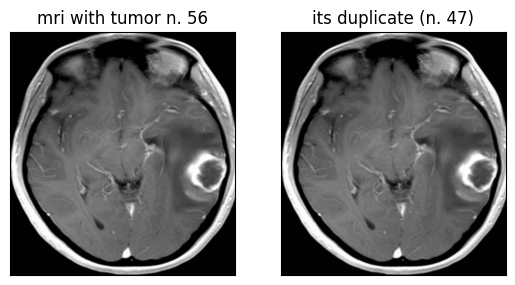

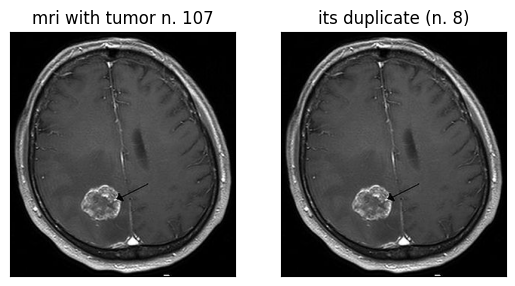

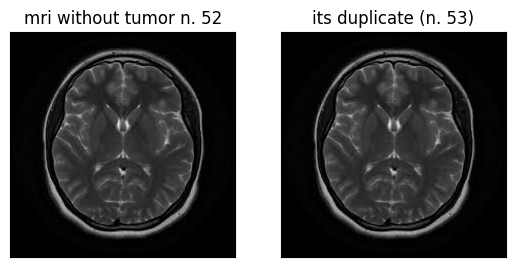

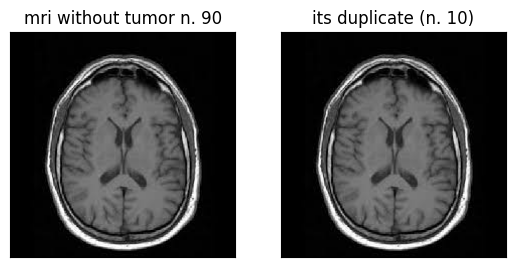

In [10]:
# Let's print some of these duplicates
show_duplicates = 2
for e in [positive_images_path, negative_images_path]:
  for file_indexes in duplicates[e][:show_duplicates]:
      title = 'mri with tumor n. '
      if e == './dataset/no/':
        title = 'mri without tumor n. '
      try:
          plt.subplot(121),plt.imshow(cv2.imread(e + str(file_indexes[0]) + '.jpg'))
          plt.title(title + str(file_indexes[1])), plt.xticks([]), plt.yticks([])

          plt.subplot(122),plt.imshow(cv2.imread(e + str(file_indexes[1]) + '.jpg'))
          plt.title('its duplicate (n. ' + str(file_indexes[0]) + ')'), plt.xticks([]), plt.yticks([])
          plt.show()
      except OSError as e:
          continue

In [11]:
# and now we remove them
for e in [positive_images_path, negative_images_path]:
  for index in duplicates[e]:
    os.remove(e+str(index[0])+'.jpg')
    #print(f'removed {str(e)+str(index[0])}.jpg')

Now that we removed the duplicates we can address the second and third problems: small & imbalanced dataset.

To address the problem of few images (we started with a small dataset and after removing the duplicates we end up with an even smaller one), we perform data augmentation.
<br>
In this paper is presented a literature overview between different augmentation techniques: https://link.springer.com/article/10.1007/s10462-023-10453-z.
<br>
<br>
In this other paper: https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/full/10.1002/jemt.23694, are presented the techniques that provide the best improvement.
<br>
The augmentation techniques used are the following: random rotation, noise addition, zooming and sharpening.

In [19]:
# Here we define the functions to performs these data augmentation techniques
import random

def random_rotation(image, angle_range=(-30, 30)):
    angle = random.uniform(*angle_range)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


def add_noise(image, noise_type="salt_pepper"):
    if noise_type == "gaussian":
        mean = 0
        var = 10
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
        noisy_image = cv2.add(image, gauss)
    elif noise_type == "salt_pepper":
        s_vs_p = 0.5
        amount = 0.004
        noisy_image = np.copy(image)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        num_pepper = np.ceil(amount * image.size * (1.0 - s_vs_p))

        # Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 255

        # Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 0
    return noisy_image


def zoom(image, zoom_factor_range=[1.05, 1.3]):
    height, width = image.shape[:2]
    zoom_factor = random.uniform(zoom_factor_range[0], zoom_factor_range[1])
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    resized_image = cv2.resize(image, (new_width, new_height))
    startx = new_width // 2 - width // 2
    starty = new_height // 2 - height // 2
    zoomed_image = resized_image[starty:starty + height, startx:startx + width]
    return zoomed_image


def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image




Here we can see one of the techniques we implemented: **random rotation**.

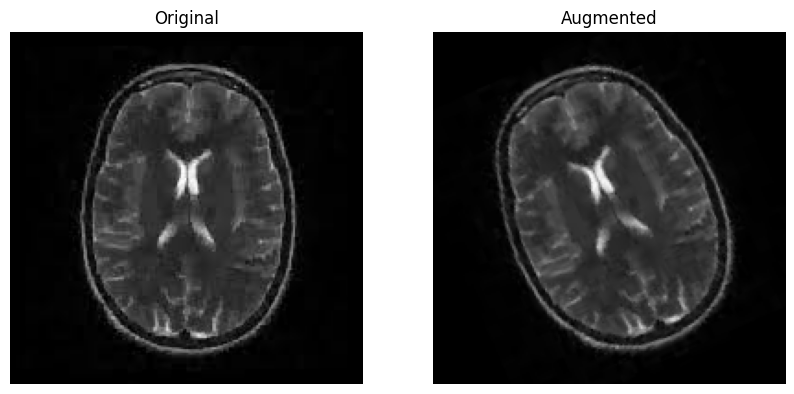

In [21]:
#import matplotlib.pyplot as plt

image_path = "./dataset/no/1.jpg"
image = cv2.imread(image_path)




# Apply augmentations
augmented_image = random_rotation(image)

# Display the original and augmented images
# Mostra le immagini affiancate
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.axis("off")
plt.title("Augmented")

plt.show()

In [14]:
# source code from https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
import imutils

def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

Additionally to augmentation we will also crop the area of the brain, this because some images contain a lot of background and also **something that is not brain scan** like text that **can influence our classification model**.

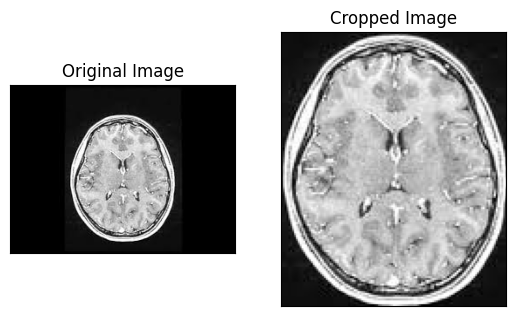

array([[[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       ...,

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[13, 13, 13],
        [13, 13, 13],
        [13, 13, 13],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]]], dtype=uint8)
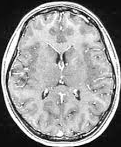

In [124]:
image_path = "./dataset/no/1.jpg"
image = cv2.imread(image_path)
crop_brain_contour(image, plot=True)

In [15]:
# Since we want balance between the two classes, we define this function that
# Augments both positive and negative datasets until they reach 1000 images
def augment_images(images, target_count):
    cropped_augmented_images = []
    while len(cropped_augmented_images) < target_count:
        image = random.choice(images)
        augmentation = random.choice([random_rotation, add_noise, zoom, sharpen])
        augmented_image = augmentation(image)
        # here we add also cropping and resize because we want to remove
        # the background and resize them to 224, 224.
        cropped_image = crop_brain_contour(augmented_image, plot=False)
        resized_image = cv2.resize(cropped_image, (224, 224))

        cropped_augmented_images.append(resized_image)
    return cropped_augmented_images

In [16]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    #print(len(images))
    return images

positive_images = load_images_from_folder(positive_images_path)
negative_images = load_images_from_folder(negative_images_path)

141
87


Let's see the data Distribution of our dataset how it looks in the beginning and at the end after performing the augmentation

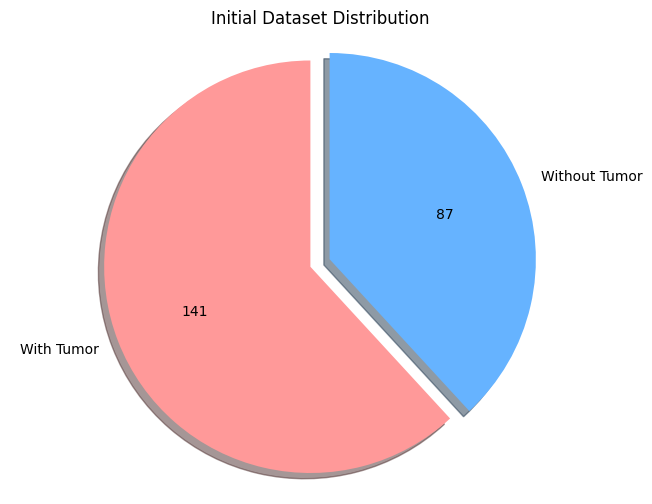

In [123]:
import matplotlib.pyplot as plt

with_tumor = os.listdir(positive_images_path)
without_tumor = os.listdir(negative_images_path)
def plot_dataset(when, positive, negative):
  # Data to plot
  labels = 'With Tumor', 'Without Tumor'
  sizes = [positive, negative]  # Number of images with tumor and without
  colors = ['#ff9999','#66b3ff']  # Colors for each section
  explode = (0.1, 0)  # looks better :)

  # Plotting the pie chart
  plt.figure(figsize=(8, 6))
  plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100),
          shadow=True, startangle=90)

  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.axis('equal')

  # Adding a title
  plt.title(when + ' Dataset Distribution')

  # Show the plot
  plt.show()

plot_dataset('Initial', len(with_tumor), len(without_tumor))


In [128]:

# now before using this images, we want to perform contour crop and resize.
# contour crop because some images have a big portion of them containing
# background. And we resize them because they have different dimensions, ranging
# from 630X630 to 225X225. I used 224 × 224 pixels like the vast majority of
# papers having done experiments on the same dataset.

positive_images_augmented = augment_images(positive_images, 1000)
negative_images_augmented = augment_images(negative_images, 1000)

#print(len(positive_images_augmented))
#print(len(negative_images_augmented))

# Since I don't want to save all the new created images in the disk.
# I put them in a dataframe.
# Create DataFrames for positive and negative images

# Function to rescale numpy arrays to [0, 255] -> now they're not like this
# [0, 255], [3, 255], [0, 239], [24, 253], [0, 249]
def rescale_image(image_array):
    scaled_images = []
    for image in image_array:
        min_val, max_val = image.min(), image.max()
        scaled_image = (image - min_val) / (max_val - min_val) * 255
        scaled_images.append(scaled_image)
    return np.array(scaled_images, dtype=np.uint8)

positive_images_augmented = rescale_image(positive_images_augmented)
negative_images_augmented = rescale_image(negative_images_augmented)


# Store images in a DataFrame
def images_to_dataframe(images, label):
    data = []
    for image in images:
        data.append({'image': image, 'label': label})
    return pd.DataFrame(data)

positive_df = images_to_dataframe(positive_images_augmented, 1)
negative_df = images_to_dataframe(negative_images_augmented, 0)


# Combine into a single DataFrame
all_images_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Optionally, shuffle the DataFrame
all_images_df = all_images_df.sample(frac=1).reset_index(drop=True)

# Display the shape of the DataFrame
#print(f'Total dataset shape: {all_images_df.shape}')

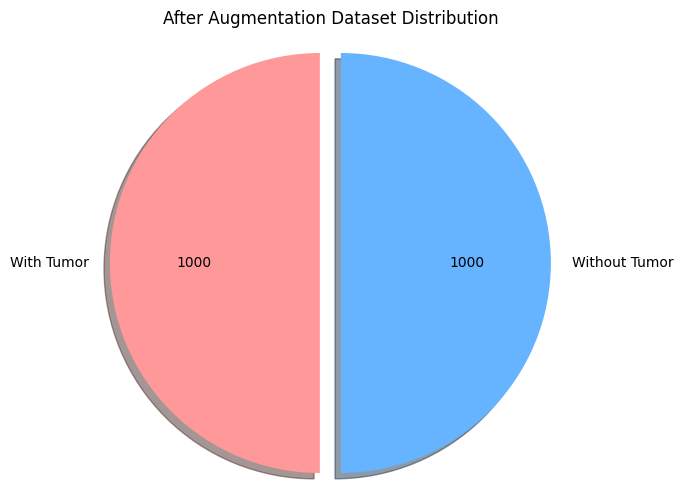

In [125]:
plot_dataset('After Augmentation', len(positive_images_augmented), len(negative_images_augmented))

So, to recap. We started from 155 positive and 98 negative images, after removing the duplicates, we ended up with 141 positive and 87 negative. Then we perform data augmentation and both classes contain 1000 samples.

Let's print some of these augmented examples to see how they look like.

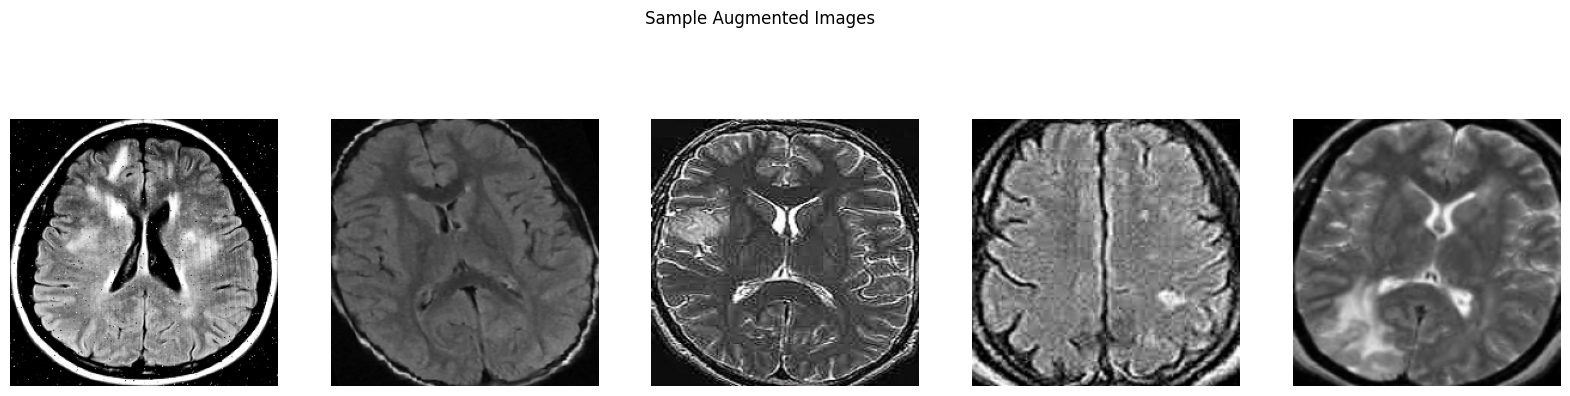

In [18]:
def display_sample_images(df, title):
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        axs[i].imshow(cv2.cvtColor(df['image'].iloc[i], cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

display_sample_images(all_images_df, 'Sample Augmented Images')

Here we define the first model: A CNN composed by 3 convolutional layers, 3 pooling layers, and 2 fully connected layers.

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
class BrainMRIImages(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label


In [131]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalizzazione comunemente usata in queste task
])

train_df, test_df = train_test_split(all_images_df, test_size=0.2, random_state=42)
train_df, dev_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_dataset = BrainMRIImages(train_df, transform=transform)
dev_dataset = BrainMRIImages(dev_df, transform=transform)
test_dataset = BrainMRIImages(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [132]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.9)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Layer 1
        x = self.pool(nn.functional.relu(self.conv_layer1(x)))
        # Layer 2
        x = self.pool(nn.functional.relu(self.conv_layer2(x)))
        # Layer 3
        x = self.pool(nn.functional.relu(self.conv_layer3(x)))
        # We add a dropout layer for improving generalization -> reduce overfitting
        #x = self.dropout(x)
        # Flatten
        x = x.view(-1, 64 * 28 * 28)
        # Fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [133]:
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [134]:
def train_loop(model, criterion, optimizer, train_loader, dev_loader, num_epochs=10):
    best_dev_loss = 9999.99
    patience = 3

    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            predicted = torch.round(torch.sigmoid(outputs))  # Predicting binary labels
            train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = train_correct / total_train

        # Check performance on dev set
        model.eval()  # Evaluation mode
        dev_loss = 0.0
        dev_correct = 0
        total_dev = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                dev_loss += loss.item() * images.size(0)
                predicted = torch.round(torch.sigmoid(outputs))
                dev_correct += (predicted == labels).sum().item()
                total_dev += labels.size(0)

        dev_accuracy = dev_correct / total_dev
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / total_train:.4f}, Train Accuracy: {train_accuracy:.4f}, Dev Loss: {dev_loss / total_dev:.4f}, Dev Accuracy: {dev_accuracy:.4f}')
        """
        # Check for improvement
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            patience = 3
            #torch.save(model.state_dict(), 'path_to_saved_model.pth')
            print('saving....')
            torch.save(model.state_dict(), 'best_model.pth')
            print('saved!')
        else:
            patience = patience - 1
            if patience < 1:
                print(f'Early stopping triggered')
                break
        """


In [135]:
def eval_loop(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid before rounding
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collect all labels and predictions for F1 score calculation
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())

    avg_loss = test_loss / total
    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions)

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    return accuracy, f1


In [136]:
train_loop(model, criterion, optimizer, train_loader, dev_loader, num_epochs=10)
#model = SimpleCNN().to(device)
#model.load_state_dict(torch.load('best_model.pth'))
accuracy_simple_cnn, f1_simple_cnn = eval_loop(model, test_loader)

Epoch 1/10, Train Loss: 0.7952, Train Accuracy: 0.5483, Dev Loss: 0.6743, Dev Accuracy: 0.5600
Epoch 2/10, Train Loss: 0.5680, Train Accuracy: 0.7117, Dev Loss: 0.5054, Dev Accuracy: 0.7650
Epoch 3/10, Train Loss: 0.3872, Train Accuracy: 0.8425, Dev Loss: 0.4083, Dev Accuracy: 0.8100
Epoch 4/10, Train Loss: 0.2102, Train Accuracy: 0.9225, Dev Loss: 0.2332, Dev Accuracy: 0.9025
Epoch 5/10, Train Loss: 0.1126, Train Accuracy: 0.9625, Dev Loss: 0.1730, Dev Accuracy: 0.9475
Epoch 6/10, Train Loss: 0.0559, Train Accuracy: 0.9817, Dev Loss: 0.2060, Dev Accuracy: 0.9350
Epoch 7/10, Train Loss: 0.0185, Train Accuracy: 0.9967, Dev Loss: 0.1824, Dev Accuracy: 0.9650
Epoch 8/10, Train Loss: 0.0042, Train Accuracy: 1.0000, Dev Loss: 0.2170, Dev Accuracy: 0.9500
Epoch 9/10, Train Loss: 0.0014, Train Accuracy: 1.0000, Dev Loss: 0.2254, Dev Accuracy: 0.9525
Epoch 10/10, Train Loss: 0.0007, Train Accuracy: 1.0000, Dev Loss: 0.2321, Dev Accuracy: 0.9475
Test Loss: 0.1311, Test Accuracy: 0.9525, F1 Scor

The CNN model reached an accuracy of **93%**.
<br>
This result is pretty good but there is something that we don't like: the error on the training set is always decreasing while the one on dev set is oscillating starting from the 4 epoch.
<br>Also the Accuracy on the train set reaches 100% if we train the model for more epochs. It memorizes the training data and this is not good, in this way we don't generalize.
<br>
<br>
To fix this we try to introduce a **dropout layer**.
<br>
Dropout is a regularization technique where randomly selected neurons are ignored during training. This prevents the model from becoming too dependent on any one neuron and encourages it to generalize better.
<br><br>
With **dropout=0.5** the model performs slightly better (**accuracy is 94%** this time) but we still have similar problems... We didn't fix them since the accuracy on the training set is not 1 but almost (99.92%) and also the accuracy on the dev set is oscillating.
<br>
I try to increase the p parameter in the **dropout** layer to **p=0.7**, also with this we did not solve the problem and the **accuracy remains 94%**.
<br>
I will do the last experiment with **p=0.9**. Also this time **nothing changes**. The same problems remain. *It seems that increasing p only delayes the overfitting that eventually occurs*.
<br>
<br>
Then I tried to add a **patience=3**. When we don't improve the loss on dev set for 3 times, we stop the training. I implemented this but I had the problem that this made the model perform worse on the test set, because it's using those weights we had when the training was stop. So in order to use the best possible model I save the model with torch.save of the model which performed best on dev set). This experiment was **successfull** since now the best model reached an **accuracy of 97% and F1 score of 0.97**.

After defining our model we wanted to try with some pretrained one and use 'Transfer Learning'. We used **ResNet50** and **VGG19**.

Import a pretrained resnet50.

In [137]:
# load a pretrained resnet50
resnet50_model = models.resnet50(pretrained=True)

# Freeze all layers except the last one, We wnat to do 'Transfer Learning'
for param in resnet50_model.parameters():
    param.requires_grad = False

num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 1)  # Change the fully connected layer for binary classification -> our task

# Unfreeze the last layer
resnet50_model.fc.requires_grad = True

resnet50_model = resnet50_model.to(device)

# Now define the optimizer to only update the parameters of the last layer
optimizer = optim.Adam(resnet50_model.fc.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [138]:
# Perform zero-shot evaluation
# zero-shot -> no training, we use only the pretrained model
accuracy_resnet50_zero, f1_resnet50_zero = eval_loop(resnet50_model, test_loader)

Test Loss: 0.7631, Test Accuracy: 0.5150, F1 Score: 0.6799


The pretrained **resnet50** model performs pretty poorly **with zero-shot evaluation**: **0.47% accuracy and 0.56 F1 Score**. This I believe is because it was trained on.

Now let's unfreeze the last layer, leaving the rest frozen, and train it for 10 epochs.

In [139]:
# Since we replaced the last layer, it is already unfrozen by default and the
#rest of the layers remain frozen because we didn't change their requires_grad status.
train_loop(resnet50_model, criterion, optimizer, train_loader, dev_loader, num_epochs=10)
accuracy_resnet50, f1_resnet50 = eval_loop(resnet50_model, test_loader)

Epoch 1/10, Train Loss: 0.6834, Train Accuracy: 0.5833, Dev Loss: 0.5358, Dev Accuracy: 0.8275
Epoch 2/10, Train Loss: 0.4861, Train Accuracy: 0.8442, Dev Loss: 0.4426, Dev Accuracy: 0.8550
Epoch 3/10, Train Loss: 0.4122, Train Accuracy: 0.8592, Dev Loss: 0.4025, Dev Accuracy: 0.8500
Epoch 4/10, Train Loss: 0.3777, Train Accuracy: 0.8550, Dev Loss: 0.3716, Dev Accuracy: 0.8500
Epoch 5/10, Train Loss: 0.3568, Train Accuracy: 0.8533, Dev Loss: 0.4032, Dev Accuracy: 0.8075
Epoch 6/10, Train Loss: 0.3514, Train Accuracy: 0.8500, Dev Loss: 0.3184, Dev Accuracy: 0.8850
Epoch 7/10, Train Loss: 0.3153, Train Accuracy: 0.8917, Dev Loss: 0.3104, Dev Accuracy: 0.8950
Epoch 8/10, Train Loss: 0.2856, Train Accuracy: 0.8975, Dev Loss: 0.2946, Dev Accuracy: 0.8975
Epoch 9/10, Train Loss: 0.2786, Train Accuracy: 0.9017, Dev Loss: 0.3045, Dev Accuracy: 0.8850
Epoch 10/10, Train Loss: 0.2696, Train Accuracy: 0.8958, Dev Loss: 0.2963, Dev Accuracy: 0.8800
Test Loss: 0.2769, Test Accuracy: 0.9075, F1 Scor

After training the last layer for 10 epochs we have a huge improvement wrt to zero_shot prediction. **Accuracy of 90% and F1 Score of 0.90** was measured on the test set. (Resnet50 is trained on the ImageNet dataset. This contains over 14 million images and circa 20k classes].

Now we want to try the same setting but this time with a VGG19 pretrained model.

In [140]:
# Load a pretrained vgg19
vgg19_model = models.vgg19(pretrained=True)

# Freeze all layers
for param in vgg19_model.parameters():
    param.requires_grad = False

# Replace the last layer to adapt to binary classification
num_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = nn.Linear(num_features, 1)

vgg19_model = vgg19_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [141]:
# zero-shot evaluation
accuracy_vgg19_zero, f1_vgg19_zero = eval_loop(vgg19_model, test_loader)

Test Loss: 0.6988, Test Accuracy: 0.5075, F1 Score: 0.2566


Like for the pretrained resnet50 model also the **vgg19** pretrained model performs 'badly' when doing **zero-shot** evaluation, in fact the **accuracy is 42% and F1 Score is 0.45**
<br>
Let's train the last layer to see if we have a good improvement.

In [142]:
# Unfreeze the last layer so we can learn
vgg19_model.classifier[-1].requires_grad = True

optimizer = optim.Adam(vgg19_model.classifier[-1].parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_loop(vgg19_model, criterion, optimizer, train_loader, dev_loader, num_epochs=10)
accuracy_vgg19, f1_vgg19 = eval_loop(vgg19_model, test_loader)

Epoch 1/10, Train Loss: 0.6028, Train Accuracy: 0.6658, Dev Loss: 0.4673, Dev Accuracy: 0.7975
Epoch 2/10, Train Loss: 0.4689, Train Accuracy: 0.7767, Dev Loss: 0.4290, Dev Accuracy: 0.8150
Epoch 3/10, Train Loss: 0.4493, Train Accuracy: 0.7892, Dev Loss: 0.3905, Dev Accuracy: 0.8325
Epoch 4/10, Train Loss: 0.4234, Train Accuracy: 0.7958, Dev Loss: 0.3858, Dev Accuracy: 0.8375
Epoch 5/10, Train Loss: 0.3907, Train Accuracy: 0.8292, Dev Loss: 0.3716, Dev Accuracy: 0.8350
Epoch 6/10, Train Loss: 0.3664, Train Accuracy: 0.8458, Dev Loss: 0.3500, Dev Accuracy: 0.8550
Epoch 7/10, Train Loss: 0.3637, Train Accuracy: 0.8350, Dev Loss: 0.3905, Dev Accuracy: 0.8450
Epoch 8/10, Train Loss: 0.3524, Train Accuracy: 0.8483, Dev Loss: 0.3367, Dev Accuracy: 0.8550
Epoch 9/10, Train Loss: 0.3469, Train Accuracy: 0.8467, Dev Loss: 0.3395, Dev Accuracy: 0.8725
Epoch 10/10, Train Loss: 0.3380, Train Accuracy: 0.8467, Dev Loss: 0.3274, Dev Accuracy: 0.8800
Test Loss: 0.2733, Test Accuracy: 0.9125, F1 Scor

Similar improvements to previous case with **resnet50** were reached: **89% accuracy and F1 score equal to 0.90**.

Then I downloaded the model of the most popular github repository that addresses the same problem: https://github.com/MohamedAliHabib/Brain-Tumor-Detection/tree/master to compare its results with the architecture that i want to build.

In [143]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [144]:
!gdown 1-zDJzf15SmGuKu4BPhYCGAf-m6EJHq8n

Downloading...
From: https://drive.google.com/uc?id=1-zDJzf15SmGuKu4BPhYCGAf-m6EJHq8n
To: /content/cnn-parameters-improvement-23-0.91.model
100% 166k/166k [00:00<00:00, 128MB/s]


In [145]:
github_model = load_model(filepath='cnn-parameters-improvement-23-0.91.model')

In [146]:
github_model.metrics_names

['loss', 'accuracy']

In [147]:
all_predictions = []
all_labels = []

# Function to resize images and convert to RGB -> the github model expects inputs like this
def resize_images(images, target_size=(240, 240)):
    resized_images = np.zeros((images.shape[0], target_size[0], target_size[1], 3))  # Ensure 3 color channels
    for i in range(images.shape[0]):
        image = images[i].transpose(1, 2, 0)  # Convert to [height, width, channels]
        if image.shape[2] == 1:  # If grayscale, convert to RGB
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        resized_images[i] = cv2.resize(image, target_size)
    return resized_images

# Iterate over batches from the DataLoader
for images, labels in test_loader:
    # Convert PyTorch tensors to NumPy arrays
    images_np = images.numpy()

    # Fix image dimensions and resize
    images_np_resized = resize_images(images_np, target_size=(240, 240))

    # Flatten labels to match the prediction output later
    labels_np = labels.numpy().flatten()

    # Predict using the TensorFlow/Keras model
    y_val_prob = github_model.predict(images_np_resized)

    # Collect predictions
    all_predictions.append(y_val_prob)
    all_labels.append(labels_np)

# Combine all predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)

# Convert predictions to binary labels using a threshold of 0.5
predictions_binary = (all_predictions > 0.5).astype(int)

# Flatten the list of label arrays to a single 1D array
true_labels_flat = np.concatenate(all_labels)

# Compute the F1 score
f1_github_model = f1_score(true_labels_flat, predictions_binary)
accuracy_github_model = accuracy_score(true_labels_flat, predictions_binary)
print(f'Accuracy: {accuracy_github_model:.4f}')
print(f'F1 Score: {f1_github_model:.4f}')


1/1 [==============================] - 0s 75ms/step
Accuracy: 0.7225
F1 Score: 0.7767


When evaluating this model we have this results: **accuracy of 72% and f1 score of 0.78**
Since with the newest models, this task became pretty easy.
<br><br>
The fact that the github model performs like this makes us understand the **importance of the image preprocessing**: we had the **same dataset** in input, we performed probably **different techniques** and his model on my data performs not as well as the other models (**different performace**).

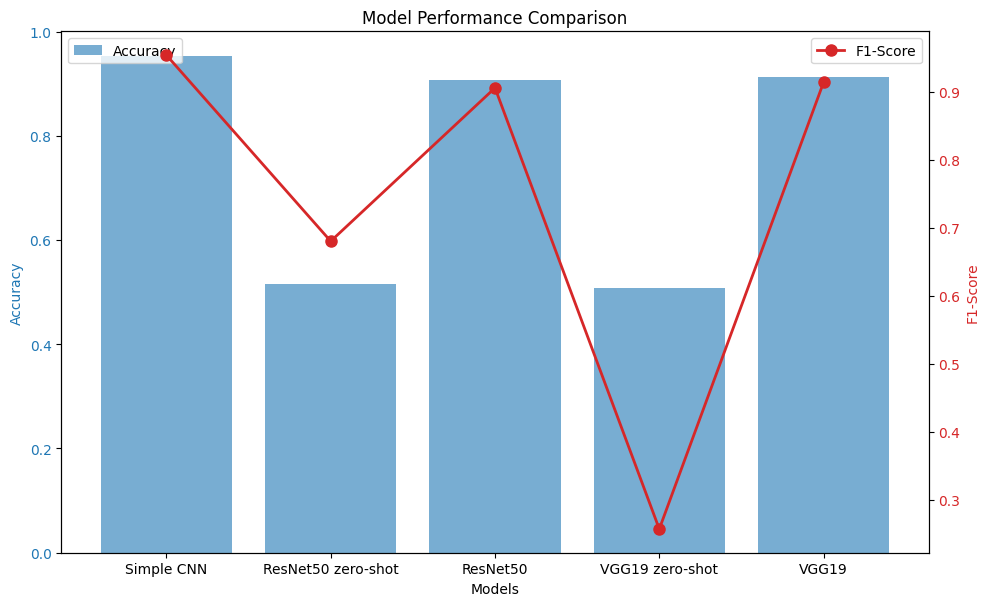

In [150]:
def plot_metrics(a_1, a_2, a_3, a_4, a_5, f1_1, f1_2, f1_3, f1_4, f1_5):

  # Model names
  models = ['Simple CNN', 'ResNet50 zero-shot', 'ResNet50', 'VGG19 zero-shot', 'VGG19']

  # Accuracy values
  accuracies = [a_1, a_2, a_3, a_4, a_5]

  # F1-score values
  f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_5]

  # Plotting the data
  fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust the figsize to make it wider

  # Plot accuracy
  ax1.set_xlabel('Models')
  ax1.set_ylabel('Accuracy', color='tab:blue')
  ax1.bar(models, accuracies, color='tab:blue', alpha=0.6, label='Accuracy')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  # Instantiate a second y-axis sharing the same x-axis
  ax2 = ax1.twinx()
  ax2.set_ylabel('F1-Score', color='tab:red')
  ax2.plot(models, f1_scores, color='tab:red', marker='o', linestyle='-', linewidth=2, markersize=8, label='F1-Score')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  # Adding legends
  fig.tight_layout()  # To ensure the labels do not overlap
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  # Adding a title
  plt.title('Model Performance Comparison')

  # Display the plot
  plt.show()

plot_metrics(accuracy_simple_cnn, accuracy_resnet50_zero, accuracy_resnet50,
             accuracy_vgg19_zero, accuracy_vgg19,
             f1_simple_cnn, f1_resnet50_zero, f1_resnet50,
             f1_vgg19_zero, f1_vgg19,)

As we can notice from the last plot our simple cnn performed better than the pretrained models. This could be happened because of several reasons.


1.   Resnet50 and VGG19 are trained on different dataset, while contains medical images (mri) their did not.
2.   Model complexity and overfitting: the cnn we designed is a pretty complex model for the task (in fact also this model overfitted) but the pretrained ones are way more complex (they use more layers).
3.    Transfer Learning limits: returning on the 1 point, this technique assumes the features learned during the first (big) training are similar/equal to the ones where we will 'transfer'. This is not the case.

